## Import dependencies

Make sure you are in the wind_gust conda environment

Basemap is deprecated. Works in this environment because python was downgraded to 3.8.10. Cartopy provides similar features may be used in the future. 

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import feature as cfeature
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.inspection import plot_partial_dependence
import pickle

### Open saved metar dataframe

In [2]:
met_df = pd.read_pickle('metar_20190801_df.pkl')
met_df_test = pd.read_pickle('metar_20200801_df.pkl')

### Plot metar locations

Uses the converted zeroes from the dataframe. 

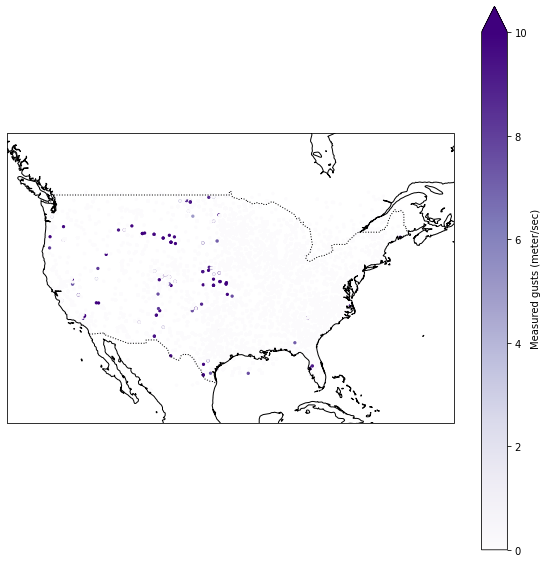

In [7]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(met_df.Longitude, met_df.Latitude, c=met_df.MetWindGust,
          cmap='Purples', vmin=0, vmax=10, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='Measured gusts (meter/sec)', extend='max')
plt.show()

### Rescaling inputs, splitting train and test

Want to still be able to plot the latitude and longitude. 

In [8]:
array = met_df.values
X = array[:, 1:8]
y = array[:, 0]

#--------Test Data--------
array_test = met_df_test.values
X_test = array_test[:, 1:8]
y_test = array_test[:, 0]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X
y_train = y


scaler = StandardScaler()
rescaled_X_train = (scaler.fit_transform(X_train[:, 3:8])) # doesn't include lon, lat
rescaled_X_test = (scaler.fit_transform(X_test[:, 3:8])) # doesn't include lon, lat

### Training and running neural net

Currently, predictions are made with the data of the same time. Inputs are scaled so they have comparable impact. Standard Scaler: z = (x - u)/s. 

u = mean, s = standard deviation.

Two hidden layers: 100, 50. Used some rudimentary judging to come to this, testing and evaluating with RMSE. Read this for more info on the optimal amount: https://www.yourdatateacher.com/2021/05/10/how-many-neurons-for-a-neural-network/

Activation function: Currently using rectified linear activation function (relu), has a flat-then linear shape, will allow for more dynamic range. Will output the input directly if it is positive, otherwise, it will output zero.

Solver: adam. Uses back-propagration. 

Max Iterations: 1500. May be a little much. 

The model is saved as mlp_wind_gust.

In [9]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                   alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                   power_t=0.5, max_iter=1500, shuffle=True, random_state=None, tol=0.0001, verbose=False,
                   warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
                   validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
mlp = mlp.fit(rescaled_X_train, y_train)

pickle.dump(mlp, open('mlp_wind_gust.pkl','wb'))

y_predict_mlp = mlp.predict(rescaled_X_test)

Rounding any predictions < 5 to zero, to match the metar process. Metar does not measure gusts less than 5 m/s.

In [12]:
y_predict_mlp[y_predict_mlp < 5] = 0
# keep this method in mind for any for loop

### Plot neural net predictions

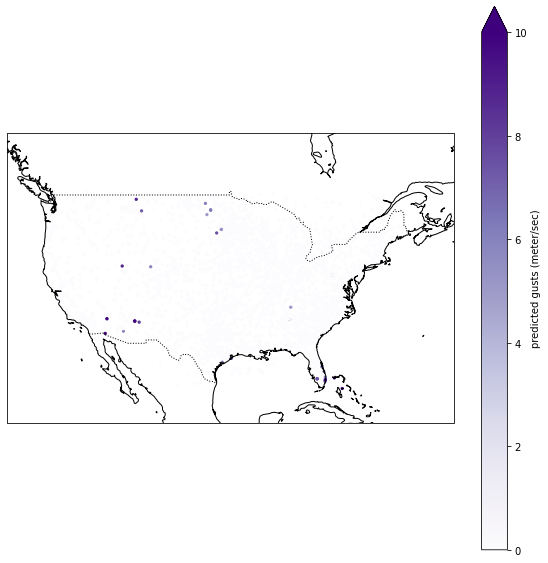

In [13]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predict_mlp, cmap='Purples',
          vmin=0, vmax=10, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='predicted gusts (meter/sec)', extend='max')
plt.show()

### Evaluating neural net predictions

Root Mean Square Error, along with other interesting features of the predictions. 

Future: Add AUROC (Area Under the Curve of the Receiver Operating Characteristic)

In [ ]:
print('RMSE:', np.sqrt(
    metrics.mean_squared_error(y_test, y_predict_mlp)).round(4))
print('Mean Absolute Error:', 
    metrics.mean_absolute_error(y_test, y_predict_mlp).round(4))
print('R-Squared Score:', 
    metrics.r2_score(y_test, y_predict_mlp).round(4))

print('Range of Training: ', np.min(y_train), ' to ', np.max(y_train))
print('Range of Test: ', np.min(y_test), ' to ', np.max(y_test))
print('Range of Predictions: ', np.min(y_predict_mlp).round(4), ' to ', np.max(y_predict_mlp).round(4))

In [ ]:
plt.scatter(y_predict_mlp, y_test, c='Navy', s=20)
plt.ylabel("Metar Gust (m/s)", size = 10)
plt.xlabel("Neural Network Gust (m/s)", size = 10)

### Loss Curve

Loss value evaluated at the end of each training step.

In [ ]:
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()
print('Loss:', mlp.loss_.round(4))
print('Best Loss:', mlp.best_loss_.round(4))
print('# of Training Samples:', mlp.t_)
print('# of Iterations:', mlp.n_iter_)
print('# of Layers:', mlp.n_layers_)
print('# of Outputs:', mlp.n_outputs_)
print('Output Activation Function:', mlp.out_activation_)

### Coefficients
The ith element in the list represents the weight matrix corresponding to layer i (scikit-learn docs).
Plots the weights for each neuron of each layer.

In [ ]:
plt.plot(mlp.coefs_[0]) #Also 1, 2
plt.title("Coefficients", fontsize=14)
plt.xlabel('Neuron')
plt.ylabel('Weights')
plt.show()

### Intercepts
The ith element in the list represents the bias vector corresponding to layer i + 1 (scikit-learn docs).  

In [ ]:
plt.plot(mlp.intercepts_[0]) #Also 1, 2
plt.title("Intercepts", fontsize=14)
plt.xlabel('Neuron')
plt.ylabel('Bias')
plt.show()

### Histograms

Comparing the frequencies of wind-gust speeds between the METAR and the neural net.

In [ ]:
hist_metar = plt.hist(y_test, bins=30, color='navy', range=[0,30], )
plt.title("METAR Readings")
plt.ylim(0,300)

In [ ]:
hist_nn = plt.hist(y_predict_mlp, bins=30, color='orange', range=[0,30])
plt.title("Neural Net Predictions")
plt.ylim(0,300)

In [ ]:
plt.scatter(X_test[:, 0], y_test,  color='navy', s=5, alpha=1)
plt.scatter(X_test[:, 0], y_predict_mlp, color='orange', s=5, alpha=0.3)
plt.title("Scatter Comparison")
plt.xlabel("Longitude", size = 10)
plt.ylabel("Wind Gust (meter/sec)", size = 10)

### Partial dependence plots
I don't understand these. Possibly need different features. 

In [ ]:
# features = [0, 1, 2, 3]

# display = plot_partial_dependence(
#      mlp, rescaled_X_train, features, kind="both", subsample=50,
#      n_jobs=3, grid_resolution=20, random_state=0
# )

## Training neural net with only measured wind gusts
Wind gusts of zero are not included in training. 

Uses the same variables as the above, so make sure to clear before re-running any lines outside of this section.

In [ ]:
subset_met_df = met_df[met_df["MetWindGust"]!=0]
subset_met_df

In [ ]:
array = subset_met_df.values
X = array[:, 1:8]
y = array[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
rescaled_X_train = (scaler.fit_transform(X_train[:, 3:8])) # doesn't include lon, lat
rescaled_X_test = (scaler.fit_transform(X_test[:, 3:8])) # doesn't include lon, lat

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                   alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                   power_t=0.5, max_iter=1500, shuffle=True, random_state=None, tol=0.0001, verbose=False,
                   warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
                   validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
mlp = mlp.fit(rescaled_X_train, y_train)

y_predict_mlp = mlp.predict(rescaled_X_test)

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predict_mlp, cmap='Purples',
          vmin=0, vmax=10, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='predicted gusts (meter/sec)', extend='max')
plt.show()

In [ ]:
hist_nn = plt.hist(y_predict_mlp, bins=30, color='orange', range=[0,30])
plt.title("Neural Net Predictions")
plt.ylim(0,200)

In [ ]:
plt.scatter(X_test[:, 0], y_test,  color='navy', s=5, alpha=1)
plt.scatter(X_test[:, 0], y_predict_mlp, color='orange', s=5, alpha=0.3)
plt.title("Scatter Comparison")
plt.xlabel("Longitude", size = 10)
plt.ylabel("Wind Gust (meter/sec)", size = 10)